<a href="https://colab.research.google.com/github/waleedsf/Facial-Emotion-Classification-using-Deep-Learning/blob/main/Technical_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # **Facial Emotion Classification using Deep Learning**

In this notebook, I will be building a classification model to classify facial expressions. The goal of this project is to develop a model that can accurately classify different facial expressions based on images of human faces.




# **Import libaries**

In [1]:
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import random
import math
import cv2
import numpy as np
from PIL import Image

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation , Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# **Get the data**
The images we're going to work with are from the [Facial Expression Dataset](https://www.kaggle.com/datasets/aadityasinghal/facial-expression-dataset?resource=download-directory&select=train), a collection of 7 different expressions categories:
1. happy
2. angry
3. sad
4. fear
5. suprise
6. disgust
7. neutral





### Download data
> **Note:** I've zipped and uploaded the data into my google drive, therefore i will access it by mountning my google drive to this notebook. 

In [3]:

#Unzip the facial_expression directory
with zipfile.ZipFile('/content/drive/MyDrive/data/facial_expression.zip', 'r') as f:
    f.extractall()

#Removing .DS_Store which is a hidden file that is created on macOS systems when a directory is accessed
for dirpath, dirnames, filenames in os.walk('/content/facial_expression'):
    for filename in filenames:
        if filename == '.DS_Store':
            os.remove(os.path.join(dirpath, filename))


#Navigate the directory's within the unziped directory above
subdirectories = os.listdir('/content/facial_expression')
subdirectories


['test', 'train']

# **Inspect Data**

In [4]:
# Define training and test directory paths
train_dir = "/content/facial_expression/train"
test_dir = "/content/facial_expression/test"


## Train dataset

In [5]:
# Create an empty list to store the image data
image_data = []

# Iterate through the subdirectories
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    # Iterate through the images in the subdirectory
    for i, image_file in enumerate(os.listdir(subdir_path)):
        if i < 10000:
            # Get the image path
            image_path = os.path.join(subdir_path, image_file)
            # Get the image class
            image_class = subdir
            # Append the image data to the list
            image_data.append([image_path, image_class])
            if i == 9999:
                break

# Create a DataFrame from the image data
df_train = pd.DataFrame(image_data, columns=['image_path', 'class'])
df_train.sample(3)


,image_path,class
2883,/content/facial_expression/train/fear/Training...,fear
22018,/content/facial_expression/train/angry/Trainin...,angry
318,/content/facial_expression/train/fear/Training...,fear


Index(['image_path', 'class'], dtype='object')

In [ ]:
#figure number of smaples per class in the training set
df_train["class"].value_counts()

happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: class, dtype: int64

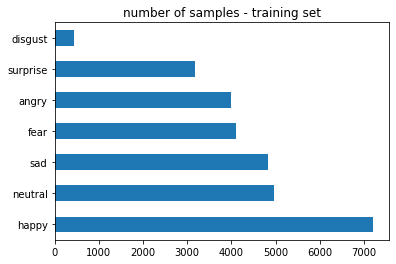

In [5]:
df_train["class"].value_counts().plot(kind='barh', title="number of samples - training set", )

> Train data is unbalanced, there are classes like **disgust** have 436 training samples, compare to **happy** which have 7215 training samples.

## Test dataset

In [6]:
# Create an empty list to store the image data
image_data = []

# Iterate through the subdirectories
for subdir in os.listdir(test_dir):
    subdir_path = os.path.join(test_dir, subdir)
    # Iterate through the images in the subdirectory
    for i, image_file in enumerate(os.listdir(subdir_path)):
        if i < 10000:
            # Get the image path
            image_path = os.path.join(subdir_path, image_file)
            # Get the image class
            image_class = subdir
            # Append the image data to the list
            image_data.append([image_path, image_class])
            if i == 9999:
                break

# Create a DataFrame from the image data
df_test = pd.DataFrame(image_data, columns=['image_path', 'class'])
df_test.sample(3)


,image_path,class
2681,/content/facial_expression/test/sad/PublicTest...,sad
2925,/content/facial_expression/test/sad/PublicTest...,sad
2371,/content/facial_expression/test/sad/PrivateTes...,sad


In [7]:
#figure number of smaples per class in the training set
df_test["class"].value_counts()

happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
disgust      111
Name: class, dtype: int64

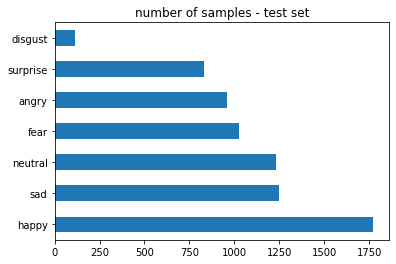

In [8]:
df_test["class"].value_counts().plot(kind='barh', title="number of samples - test set", )

## Create a function to plot the images 

In [85]:

def plot_images(df):

    """
      Plot an images within a specific dataframe

  Args: 
      df: dataframe that contains the images 
  """

  
    plt.figure(figsize=(12, 6))
    random_indices = random.sample(range(len(df)), 15)
    random_data = df.iloc[random_indices]
    for i, (index, row) in enumerate(random_data.iterrows()):
        img = Image.open(row['image_path'])
        plt.subplot(3,5,i+1)
        plt.imshow(img, cmap="gray")
        plt.title(row['class'])
        plt.axis('off')
    plt.show()


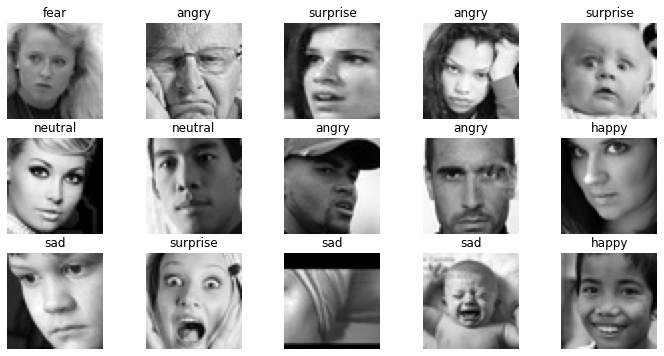

In [90]:
plot_images(df_train)

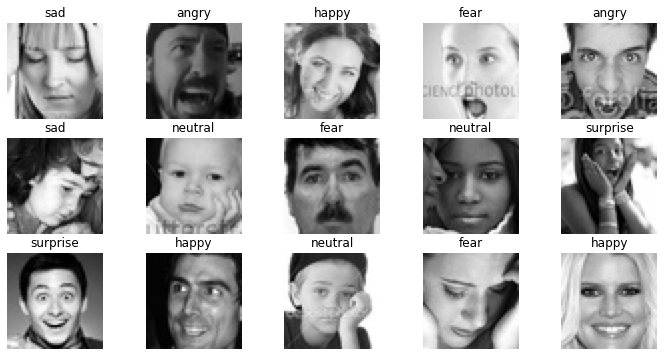

In [97]:
plot_images(df_test)

> Data seems to have some issues regards its quality, some of the images were not clear enough to confidently determine which class they belonged to, and there were also some instances of non-facial images being included in the dataset.


# **Modeling**




> ## First experement

 The model approach for this experement involves the implementation of a convolutional neural network (CNN) model to evaluate its performance on the original dataset. Preprocessing techniques will include rescaling of the data and utilization of all available images during the training phase.

In [12]:
# Create train and test data generators and rescale data 
train_datagen = ImageDataGenerator(rescale= 1/255.0)
test_datagen = ImageDataGenerator(rescale = 1/255.0)



In [13]:
train_data = train_datagen.flow_from_dataframe(df_train,
                                              x_col="image_path",
                                              y_col="class",
                                               target_size=(48,48),
                                               color_mode="grayscale",
                                               batch_size=32,
                                               class_mode='categorical'
                                               )


test_data = test_datagen.flow_from_dataframe(df_test,
                                                x_col="image_path",
                                                y_col="class",
                                               target_size=(48,48),
                                               color_mode="grayscale",
                                               )

                                          

Found 28709 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


### model

In [ ]:
model = Sequential()

# Block-1

model.add(Conv2D(32,(3,3),padding='same',input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block-2 

model.add(Conv2D(64,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block-3

model.add(Conv2D(128,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block-4 

model.add(Conv2D(256,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Block-5

model.add(Flatten())
model.add(Dense(64,))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Block-6

model.add(Dense(64,))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Block-7

model.add(Dense(7,))
model.add(Activation('softmax'))

print(model.summary())




# earlystop = EarlyStopping(monitor='val_accuracy',
#                           patience=3,
#                           verbose=1,
#                           restore_best_weights=True
#                           )



model.compile(loss='categorical_crossentropy',
              optimizer = Adam(),
              metrics=['accuracy'])



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 activation_22 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_10 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 activation_23 (Activation)  (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_11 (Bat  (None, 48, 48, 32)       128       
 chNormalization)                                     

### model result

In [ ]:
history_0 = model.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))


Epoch 1/20
898/898 [==============================] - 13s 13ms/step - loss: 1.5580 - accuracy: 0.3984 - val_loss: 1.3430 - val_accuracy: 0.4886
Epoch 2/20
898/898 [==============================] - 11s 13ms/step - loss: 1.2474 - accuracy: 0.5225 - val_loss: 1.3197 - val_accuracy: 0.4908
Epoch 3/20
898/898 [==============================] - 11s 13ms/step - loss: 1.1138 - accuracy: 0.5792 - val_loss: 1.3392 - val_accuracy: 0.5096
Epoch 4/20
898/898 [==============================] - 11s 13ms/step - loss: 1.0236 - accuracy: 0.6164 - val_loss: 1.1595 - val_accuracy: 0.5720
Epoch 5/20
898/898 [==============================] - 12s 13ms/step - loss: 0.9399 - accuracy: 0.6478 - val_loss: 1.1156 - val_accuracy: 0.6002
Epoch 6/20
898/898 [==============================] - 11s 13ms/step - loss: 0.8427 - accuracy: 0.6866 - val_loss: 1.0790 - val_accuracy: 0.6085
Epoch 7/20
898/898 [==============================] - 11s 13ms/step - loss: 0.7303 - accuracy: 0.7316 - val_loss: 1.1201 - val_accuracy:

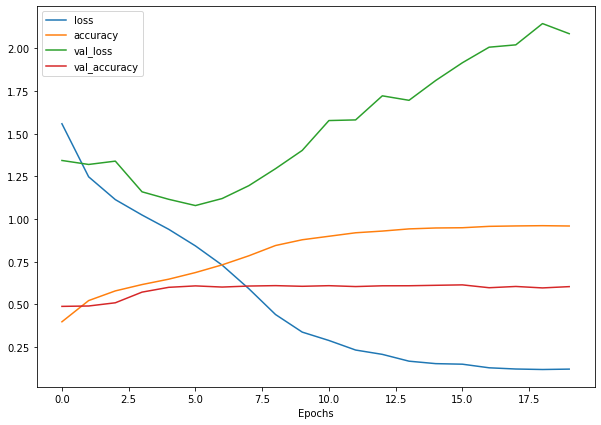

In [ ]:
pd.DataFrame(history_0.history).plot(figsize=(10, 7) , xlabel="Epochs");


The first experement shows that the model overfit the data.

> ## Second experement

The first experement showed that the model overfit the data, for that i will modify the model and use dropouts in each layer.

### Model - Dropout

In [7]:
model = Sequential()

# Block-1

model.add(Conv2D(32,(3,3),padding='same',input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.2))

# Block-2 

model.add(Conv2D(64,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.2))

# Block-3

model.add(Conv2D(128,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.2))

# Block-4 

model.add(Conv2D(256,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.2))

# Block-5

model.add(Flatten())
model.add(Dense(64,))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))

# Block-6

model.add(Dense(64,))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))

# Block-7

model.add(Dense(7,))
model.add(Activation('softmax'))





earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )



model.compile(loss='categorical_crossentropy',
              optimizer = Adam(),
              metrics=['accuracy'])



In [ ]:
# First batch
train_data[0][0].shape

(32, 48, 48, 1)

In [ ]:
model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

### Model Result

In [ ]:
history_1 = model.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[earlystop])

Epoch 1/20
898/898 [==============================] - 24s 14ms/step - loss: 2.1165 - accuracy: 0.2071 - val_loss: 1.7518 - val_accuracy: 0.2792
Epoch 2/20
898/898 [==============================] - 12s 13ms/step - loss: 1.6249 - accuracy: 0.3577 - val_loss: 1.9042 - val_accuracy: 0.2693
Epoch 3/20
898/898 [==============================] - 12s 13ms/step - loss: 1.4107 - accuracy: 0.4565 - val_loss: 1.3513 - val_accuracy: 0.4762
Epoch 4/20
898/898 [==============================] - 12s 13ms/step - loss: 1.3107 - accuracy: 0.5032 - val_loss: 1.2034 - val_accuracy: 0.5366
Epoch 5/20
898/898 [==============================] - 12s 13ms/step - loss: 1.2439 - accuracy: 0.5348 - val_loss: 1.2920 - val_accuracy: 0.5149
Epoch 6/20
898/898 [==============================] - 12s 13ms/step - loss: 1.1851 - accuracy: 0.5639 - val_loss: 1.1156 - val_accuracy: 0.5793
Epoch 7/20
898/898 [==============================] - 12s 13ms/step - loss: 1.1395 - accuracy: 0.5795 - val_loss: 1.1112 - val_accuracy:

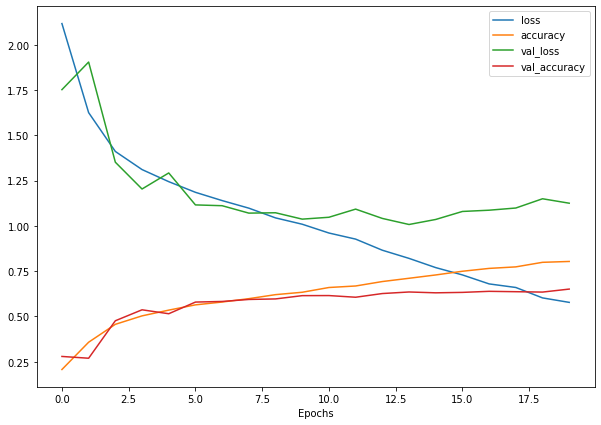

In [ ]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7) , xlabel="Epochs");


> The model achieved an accuracy of 65% on the original dataset in 20 epochs.

> ## Third experement

In an effort to enhance the performance of the model, I will be implementing data augmentation techniques as a means of expanding the training dataset using the previous model with dropouts."




In [10]:
# Applying Data augmentation 
train_datagen2  = ImageDataGenerator(rescale = 1/255.0,
                              rotation_range=25,
                             width_shift_range=0.1,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest',
                            )




In [14]:
train_data_aug = train_datagen2.flow_from_dataframe(df_train,
                                                x_col="image_path",
                                                y_col="class",
                                               target_size=(48,48),
                                               color_mode="grayscale",
                                               batch_size=32,
                                               class_mode='categorical'
                                               )

test_data = test_datagen.flow_from_dataframe(df_test,
                                                x_col="image_path",
                                                y_col="class",
                                               target_size=(48,48),
                                               color_mode="grayscale",
                                               )


Found 28709 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


### Model Result

In [ ]:

history_2 = model.fit(train_data_aug,
                        epochs=20,
                        steps_per_epoch=len(train_data_aug),
                        validation_data=test_data)

Epoch 1/20
898/898 [==============================] - 25s 28ms/step - loss: 1.2471 - accuracy: 0.5453 - val_loss: 1.0329 - val_accuracy: 0.6098
Epoch 2/20
898/898 [==============================] - 25s 28ms/step - loss: 1.1806 - accuracy: 0.5688 - val_loss: 1.0236 - val_accuracy: 0.6159
Epoch 3/20
898/898 [==============================] - 25s 28ms/step - loss: 1.1552 - accuracy: 0.5753 - val_loss: 1.0183 - val_accuracy: 0.6151
Epoch 4/20
898/898 [==============================] - 25s 28ms/step - loss: 1.1491 - accuracy: 0.5794 - val_loss: 0.9961 - val_accuracy: 0.6307
Epoch 5/20
898/898 [==============================] - 25s 28ms/step - loss: 1.1338 - accuracy: 0.5856 - val_loss: 0.9717 - val_accuracy: 0.6374
Epoch 6/20
898/898 [==============================] - 25s 28ms/step - loss: 1.1296 - accuracy: 0.5861 - val_loss: 1.0039 - val_accuracy: 0.6244
Epoch 7/20
898/898 [==============================] - 26s 28ms/step - loss: 1.1200 - accuracy: 0.5920 - val_loss: 1.0269 - val_accuracy:

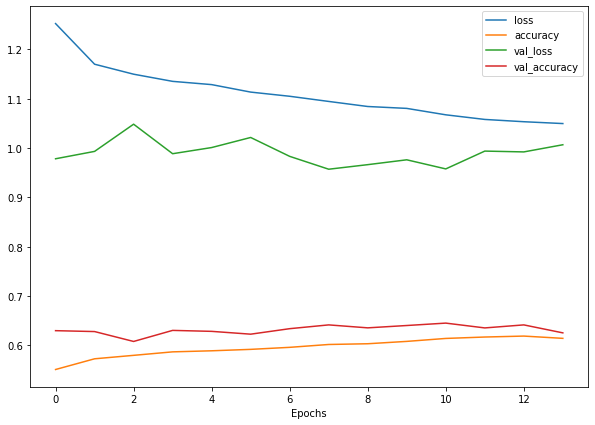

In [ ]:
pd.DataFrame(history_2.history).plot(figsize=(10, 7) , xlabel="Epochs");


>  Implementing data augmentation technique did not result in an improving in model performance within 20 epochs, and due to efficiency and lack of resources will be using the original data.

> ## Fourth experement


### Fine Tuning

- Trying to improve the performance of the model, I will be utilizing a learning rate fine-tuning to identify the optimal learning rate for our model on the original dataset.



In [ ]:


# traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20)) 


callbacks = [lr_scheduler]



model.compile(loss='categorical_crossentropy',
              optimizer = Adam(),
              metrics=['accuracy'])



In [ ]:

history = model.fit_generator(
                train_data,
                epochs=40,
                callbacks=callbacks,
                validation_data=test_data,)


Epoch 1/40


<ipython-input-54-1b5831c78e46>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


898/898 [==============================] - 14s 14ms/step - loss: 2.7172 - accuracy: 0.1799 - val_loss: 1.9273 - val_accuracy: 0.2758 - lr: 1.0000e-04
Epoch 2/40
898/898 [==============================] - 12s 14ms/step - loss: 2.2883 - accuracy: 0.2195 - val_loss: 1.7849 - val_accuracy: 0.3012 - lr: 1.1220e-04
Epoch 3/40
898/898 [==============================] - 12s 14ms/step - loss: 2.0463 - accuracy: 0.2651 - val_loss: 1.6541 - val_accuracy: 0.3660 - lr: 1.2589e-04
Epoch 4/40
898/898 [==============================] - 12s 14ms/step - loss: 1.8316 - accuracy: 0.3253 - val_loss: 1.5478 - val_accuracy: 0.4081 - lr: 1.4125e-04
Epoch 5/40
898/898 [==============================] - 12s 14ms/step - loss: 1.6715 - accuracy: 0.3740 - val_loss: 1.5337 - val_accuracy: 0.4099 - lr: 1.5849e-04
Epoch 6/40
898/898 [==============================] - 12s 14ms/step - loss: 1.5632 - accuracy: 0.4002 - val_loss: 1.3843 - val_accuracy: 0.4753 - lr: 1.7783e-04
Epoch 7/40
898/898 [=========================

The results of 40 epochs our learning rate fine-tuning revealed that the optimal learning rate for our model is 0.0014.

In [16]:
#Set the learning rate at 0.0014
model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0014),
                     metrics=['accuracy'])

### Model Result

In [ ]:
history_4 = model.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data), # original data
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[earlystop])

Epoch 1/20
898/898 [==============================] - 13s 13ms/step - loss: 0.2457 - accuracy: 0.9202 - val_loss: 1.5726 - val_accuracy: 0.6539
Epoch 2/20
898/898 [==============================] - 11s 13ms/step - loss: 0.2149 - accuracy: 0.9327 - val_loss: 1.5739 - val_accuracy: 0.6503
Epoch 3/20
898/898 [==============================] - 11s 13ms/step - loss: 0.1999 - accuracy: 0.9370 - val_loss: 1.6360 - val_accuracy: 0.6513
Epoch 4/20
898/898 [==============================] - 12s 13ms/step - loss: 0.1934 - accuracy: 0.9393 - val_loss: 1.6889 - val_accuracy: 0.6452
Epoch 4: early stopping


Increasing the learning rate from 0.001 to 0.0014 improved the model performance, within the **first epoch** we reached the highest model result so far. but the model overfit the data.

> ## Fifth experement

In this experiment, we sought to investigate the effect of increasing the dropout ratio and using a tuned learning rate of 0.0014 on the performance of a neural network model.




### Model - modified dropouts

In [17]:
model = Sequential()

# Block-1

model.add(Conv2D(32,(3,3),padding='same',input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',input_shape=(48,48,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.3))

# Block-2 

model.add(Conv2D(64,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.4))

# Block-3

model.add(Conv2D(128,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.4))

# Block-4 

model.add(Conv2D(256,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.2))

# Block-5

model.add(Flatten())
model.add(Dense(64,))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))

# Block-6

model.add(Dense(64,))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))

# Block-7

model.add(Dense(7,))
model.add(Activation('softmax'))





earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )




In [ ]:
#Set the learning rate at 0.0014
model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0014),
                     metrics=['accuracy'])

### Model result

In [23]:
history_6 = model.fit(train_data, #original data
                        epochs=20,
                        steps_per_epoch=len(train_data), 
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/20
898/898 [==============================] - 21s 21ms/step - loss: 0.6355 - accuracy: 0.7829 - val_loss: 1.1095 - val_accuracy: 0.6435
Epoch 2/20
898/898 [==============================] - 21s 24ms/step - loss: 0.6369 - accuracy: 0.7819 - val_loss: 1.1045 - val_accuracy: 0.6400
Epoch 3/20
898/898 [==============================] - 19s 21ms/step - loss: 0.6348 - accuracy: 0.7829 - val_loss: 1.1419 - val_accuracy: 0.6390
Epoch 4/20
898/898 [==============================] - 19s 22ms/step - loss: 0.6285 - accuracy: 0.7842 - val_loss: 1.1155 - val_accuracy: 0.6418
Epoch 5/20
898/898 [==============================] - 19s 21ms/step - loss: 0.6064 - accuracy: 0.7923 - val_loss: 1.1890 - val_accuracy: 0.6250
Epoch 6/20
898/898 [==============================] - 19s 21ms/step - loss: 0.5939 - accuracy: 0.7992 - val_loss: 1.1153 - val_accuracy: 0.6443
Epoch 7/20
898/898 [==============================] - 19s 21ms/step - loss: 0.5748 - accuracy: 0.8031 - val_loss: 1.2214 - val_accuracy:

🎊 The results indicate that by increasing the dropout ratio and using a tuned learning rate, we were able to achieve the best performance so far, with an accuracy of 65.5%. 

# Save model

In [24]:
# save the model to my google drive
tf.keras.models.save_model(
    model,
    '/content/drive/MyDrive/emotion_classifier/model_v2',
    overwrite=True,
    include_optimizer=True,
    save_format='h5',
    signatures=None,
    options=None
)


# **Summary**

In this notebook, I aimed to improve the performance of a neural network model by trying different models with different dropout ratios and original and augmented data, as well as a tuned learning rate. The results showed that the best score of 65.5% was achieved using the original data with a tuned learning rate and dropouts. However, the model exhibited signs of overfitting. To mitigate this issue, it would be beneficial to use more data or augmented data instead of the original data to improve the model's generalization performance. 

In [2]:
!pip freeze > requirements.txt
